# Segregation

This notebook presents an agent-based model of segregation dynamics.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to work with a spatial grid and create animations. 

In [1]:
# Model design
import agentpy as ap
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

## About the model

The model is based on the [NetLogo Segregation model](http://ccl.northwestern.edu/netlogo/models/Segregation) from Uri Wilensky, who describes it as follows:

>This project models the behavior of two types of agents in a neighborhood. The orange agents and blue agents get along with one another. But each agent wants to make sure that it lives near some of "its own." That is, each orange agent wants to live near at least some orange agents, and each blue agent wants to live near at least some blue agents. The simulation shows how these individual preferences ripple through the neighborhood, leading to large-scale patterns.

## Model definition

To start, we define our agents, who initiate with a random group
and have two methods to check whether they are happy and to 
move to a new location if they are not.

In [2]:
class Person(ap.Agent):
    
    def setup(self):
        self.happy = False
        self.group = random.choice(range(self.p.n_groups))
        
    def update_happiness(self):
        """ Be happy if rate of similar neighbors is high enough. """
        neighbors = self.neighbors()
        similar = len([n for n in neighbors if n.group == self.group])
        similar_min = self.p.want_similar * len(neighbors)
        self.happy = True if similar >= similar_min else False  
        
    def find_new_home(self):
        """ Move to random free spot and update free spots. """
        old_spot = self.position()
        new_spot = random.choice(self.model.free_spots)
        self.move_to(new_spot)
        self.model.free_spots.remove(new_spot)
        self.model.free_spots.append(old_spot)

Next, we define our model, which consists of our agens and a spatial grid environment.
At every step, unhappy people move to a new location.
After every step (update), agents update their happiness.
If all agents are happy, the simulation is stopped.

In [3]:
class SegregationModel(ap.Model):
    
    def setup(self):      
        # Create grid with agents 
        self.add_grid(self.p.size)       
        self.n_agents = int(self.p.density * (self.p.size ** 2))
        self.env.add_agents(self.n_agents, Person, random=True)  

        # Create list of free spots
        self.free_spots = []
        for pos, agents in self.env.items():
            if len(agents) == 0:
                self.free_spots.append(pos)
            
    def step(self):
        # Move unhappy people
        self.unhappy_people.find_new_home()   
        
    def update(self):
        # Update list of unhappy people
        self.agents.update_happiness()
        self.unhappy_people = self.agents.select(self.agents.happy == False)
        
        # Stop simulation if all are happy
        if len(self.unhappy_people) == 0: 
            self.stop() 

    def get_segregation(self):
        # Calculate average percentage of similar neighbors
        similarity = 0
        for a in self.agents:
            neighbors = a.neighbors()
            n_neighbors = len(neighbors)
            if n_neighbors > 0:
                similarity += len([n for n in neighbors 
                                   if a.group == n.group]) / n_neighbors
        return round(similarity / self.n_agents, 2)
            
    def end(self): 
        # Measure segregation at the end of the simulation
        self.measure('segregation', self.get_segregation())

## Single-run animation

Uri Wilensky explains the dynamic of the segregation model as follows:

>Agents are randomly distributed throughout the neighborhood. But many agents are "unhappy" since they don't have enough same-color neighbors. The unhappy agents move to new locations in the vicinity. But in the new locations, they might tip the balance of the local population, prompting other agents to leave. If a few agents move into an area, the local blue agents might leave. But when the blue agents move to a new area, they might prompt orange agents to leave that area.
>
>Over time, the number of unhappy agents decreases. But the neighborhood becomes more segregated, with clusters of orange agents and clusters of blue agents.
>
>In the case where each agent wants at least 30% same-color neighbors, the agents end up with (on average) 70% same-color neighbors. So relatively small individual preferences can lead to significant overall segregation.

To observe this effect in our model, we can create an animation of a single run.  
To do so, we first set up an instance of our model with a chosen set of parameters.

In [4]:
parameters = {
    'want_similar': 0.3, # For agents to be happy
    'n_groups': 2, # Number of groups
    'density': 0.95, # Density of population
    'size': 50, # Height and length of the grid
    'steps': 50  # Maximum number of steps
    }

model = SegregationModel(parameters)

We can now create an animation plot and display it directly in Jupyter as follows.

In [5]:
def animation_plot(model, ax):
    group_grid = model.env.attribute('group')
    ap.gridplot(group_grid, cmap='Accent', ax=ax)
    ax.set_title(f"Segregation model \n Time-step: {model.t}, "
                 f"Segregation: {model.get_segregation()}")

fig, ax = plt.subplots() 
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml())

## Multi-run experiment

To explore how different individual preferences lead to different average levels of segregation, we can conduct a multi-run experiment.
To do so, we first prepare a parameter sample that includes different values for peoples' preferences and the population density.

In [6]:
parameter_ranges = dict(parameters)
parameter_ranges.update({
    'want_similar': (0,0.125, 0.25, 0.375, 0.5, 0.625), 
    'density': (0.5, 0.7, 0.95),
})
sample = ap.sample_discrete(parameter_ranges)

We now run an experiment where we simulate each parameter combination in our sample over 5 iterations.

In [7]:
exp = ap.Experiment(SegregationModel, sample, iterations=5)
results = exp.run()

Scheduled runs: 90
Completed: 90, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:45.371520


Finally, we can arrange the results from our experiment into a dataframe with measures and variable parameters, 
and use the seaborn library to visualize the different segregation levels over our parameter ranges.

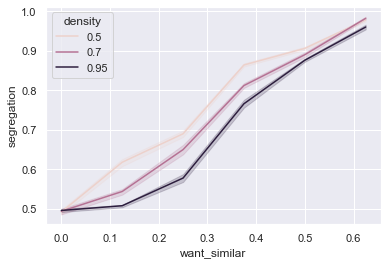

In [8]:
data = results.arrange_measures() 

sns.set()
ax = sns.lineplot(data=data, x='want_similar', y='segregation', hue='density')